# UnSupervisedIOHMM

In [2]:
from __future__ import  division

import json
import warnings

import numpy as np
import pandas as pd

from IOHMM import UnSupervisedIOHMM
from IOHMM import OLS, DiscreteMNL, CrossEntropyMNL

warnings.simplefilter("ignore")

## Load data

In [3]:
data = pd.read_csv("data/TSLA.csv")
data.head()
data = data.dropna()

input_data = data[['Open', 'High', 'Low', 'Close', 'Volume']][:-1]


# close price of the next day
output_data = data['Close'][1:]
# to start from 0 index
output_data.index = range(len(output_data))

output_data.name = 'Close-next-day'

data = pd.concat([input_data, output_data], axis=1)

data.head()
print(len(data))

3259


# Example 1

## Set up a simple model manully

In [4]:
# set two hidden states
SHMM = UnSupervisedIOHMM(num_states=3, max_EM_iter=200, EM_tol=1e-6)

# This model has only one output which is modeled by a linear regression model
SHMM.set_models(model_emissions = [OLS()], 
                model_transition=CrossEntropyMNL(solver='lbfgs'),
                model_initial=CrossEntropyMNL(solver='lbfgs'))

# We don't set any covariates to this OLS model
SHMM.set_inputs(covariates_initial = ['Open', 'High', 'Low', 'Close', 'Volume'], covariates_transition = ['Open', 'High', 'Low', 'Close', 'Volume'], covariates_emissions = [['Open', 'High', 'Low', 'Close', 'Volume'],['Open', 'High', 'Low', 'Close', 'Volume'],['Open', 'High', 'Low', 'Close', 'Volume']])

SHMM.set_outputs([['Close-next-day']])

# we only have a list of one sequence.
SHMM.set_data([data])

## Start training

In [5]:
SHMM.train()

## See the training results

In [6]:
print(SHMM.model_initial)
print(SHMM.model_transition)
print(SHMM.model_emissions)

[<IOHMM.linear_models.CrossEntropyMNL object at 0x171a06e50>, <IOHMM.linear_models.CrossEntropyMNL object at 0x171a06df0>, <IOHMM.linear_models.CrossEntropyMNL object at 0x171a06d90>]
[[<IOHMM.linear_models.OLS object at 0x171a06850>], [<IOHMM.linear_models.OLS object at 0x171a06820>], [<IOHMM.linear_models.OLS object at 0x171a06640>]]


In [7]:
print("Initial state distribution")
print(SHMM.model_initial.coef)

print("Transition matrix")
print(SHMM.model_transition[0].coef)
print(SHMM.model_transition[1].coef)
print(SHMM.model_transition[2].coef)

print("Emission model")
print(SHMM.model_emissions[0][0].coef)
print(SHMM.model_emissions[1][0].coef)
print(SHMM.model_emissions[2][0].coef)

Initial state distribution
[[-2.68721234e-15 -3.40380322e-15 -4.47868809e-15 -3.14224602e-15
  -4.27983438e-15 -7.56435495e-07]
 [ 5.37442469e-15  6.80760644e-15  8.95737619e-15  6.28449204e-15
   8.55966875e-15  1.51287099e-06]
 [-2.68721234e-15 -3.40380322e-15 -4.47868809e-15 -3.14224602e-15
  -4.27983438e-15 -7.56435495e-07]]
Transition matrix
[[ 3.36308988e-14  6.86663397e-12  7.02787898e-12  6.69096209e-12
   6.86365833e-12  4.54165318e-06]
 [-1.67622802e-14 -3.43324025e-12 -3.51386275e-12 -3.34540834e-12
  -3.43175646e-12 -2.27072918e-06]
 [-1.68686502e-14 -3.43338969e-12 -3.51401219e-12 -3.34555375e-12
  -3.43190187e-12 -2.27092824e-06]]
[[-1.10378961e-13 -2.10699170e-13 -2.14990673e-13 -2.05921893e-13
  -2.10412964e-13 -2.17836998e-06]
 [ 3.38377101e-14 -6.23391114e-15 -2.44705332e-15 -8.15234721e-15
  -6.72973962e-15  1.33297887e-06]
 [ 7.65412513e-14  2.16933081e-13  2.17437726e-13  2.14074241e-13
   2.17142704e-13  8.45391110e-07]]
[[-6.50282757e-14 -4.09547363e-13 -4.083284

In [8]:
# The scale/dispersion of the OLS model for each hidden states
print(np.sqrt(SHMM.model_emissions[0][0].dispersion))
print(np.sqrt(SHMM.model_emissions[1][0].dispersion))
print(np.sqrt(SHMM.model_emissions[2][0].dispersion))

[[8.67150453]]
[[0.05989296]]
[[0.49065709]]


In [9]:
viterbi_path = SHMM.viterbi()
print(viterbi_path)

[1 1 1 ... 0 0 0]


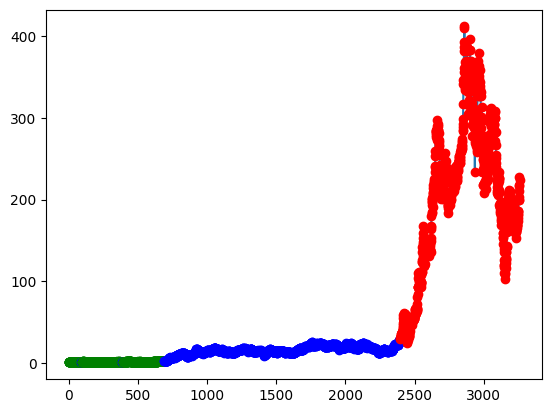

In [12]:
# plot the output data and the hidden states, i want that the line of the close data becomes red when state is 0, grey when state is 1 and blue when state is 2
import matplotlib.pyplot as plt
plt.plot(data['Close-next-day'])
for i in range(len(viterbi_path)):
    if viterbi_path[i] == 0:
        plt.plot(i, data['Close-next-day'][i], 'ro')
    elif viterbi_path[i] == 1:
        plt.plot(i, data['Close-next-day'][i], 'go')
    else:
        plt.plot(i, data['Close-next-day'][i], 'bo')
plt.show()

In [27]:
import hmmlearn.hmm as hmm

model = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=1000)
model.fit(data[['Close-next-day']])
hidden_states = model.predict(data[['Close-next-day']])
print(hidden_states)

[1 1 1 ... 2 2 2]


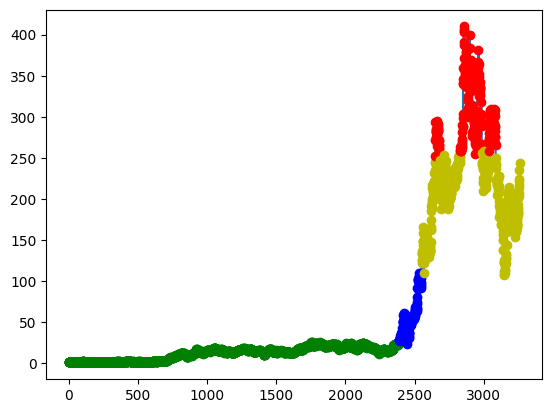

In [28]:
# plot the output data and the hidden states, i want that the line of the close data becomes red when state is 0, grey when state is 1 and blue when state is 2
import matplotlib.pyplot as plt
plt.plot(data['Close-next-day'])
for i in range(len(hidden_states)):
    if hidden_states[i] == 0:
        plt.plot(i, data['Close-next-day'][i], 'ro')
    elif hidden_states[i] == 1:
        plt.plot(i, data['Close-next-day'][i], 'go')
    elif hidden_states[i] == 2:
        plt.plot(i, data['Close-next-day'][i], 'yo')
    else:
        plt.plot(i, data['Close-next-day'][i], 'bo')
plt.show()